# Masa total y Radio total de modelos con polítropa maestra

Este código calcula la masa total ($M$), el radio total ($r_b$) y la compacidad ($\mu_b$) de esferas anisótropas relativistas con ecuación de estado polítropa maestra
\begin{equation}
    P = \kappa \rho^{1+\frac{1}{n}} + \alpha \rho - \beta \,.
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import integrate
from scipy.integrate import solve_ivp

In [2]:
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
params = {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

# Modelado de objetos compactos

## Ecuaciones de estructura

Las ecuaciones de estructura son el resultado de manipular las ecuaciones de campo de Einstein para una métrica y un tensor de energía dado, y son las ecuaciones que hay que resolver para modelar objetos compactos. En el caso de configuraciones estáticas con simetría esférica y anisotropía en la presión, las ecuaciones de estructura consisten en

\begin{eqnarray}
P^{\prime} &=& - \left(\rho + P \right) \frac{m + 4 \pi r^{3} P}{r(r - 2m)} + \frac{2}{r} \left(P_{\perp} - P \right)  \label{EqHid} \tag{1} \\
m^{\prime} &=& 4 \pi r^{2} \rho \label{MasDif} \tag{2}
\end{eqnarray}
donde $\rho$ es densidad de energía, $m$ es masa, $P$ es presión radial, $P_{\perp}$ es presión tangencial y la prima denota derivada respecto a $r$.

## Ecuación de Estado

Una ecuación de estado (EoS por sus siglas en inglés) es un modelo matemático, entre variables de estado, que describe los procesos físicos más importantes que ocurren en un sistema termodinámico.

La EoS polítropa maestra consiste en una relación tal que
\begin{equation}
P = \kappa \rho^{1+\frac{1}{n}} + \alpha \rho - \beta \,. \label{PoliMaestra} \tag{3}
\end{equation}

Por otra parte, se supone que la anisotropía en la presión es de la forma
\begin{equation}
\Delta\equiv P_{\perp} - P = C r (\rho + P) \frac{m + 4 \pi r^3 P}{r(r-2m)} \,, \label{Anisotropia} \tag{4}
\end{equation}
tal que la ecuación (1) queda como
\begin{equation}
\frac{\mathrm{d}P}{\mathrm{d}r} = - h \frac{(\rho + P)(m + 4 \pi  r^3 P)}{r(r-2m)} \,, \label{EqHidCos} \tag{5}
\end{equation}
donde $h = 1 - 2C$, y $C$ cuantifica la anisotropía en el modelo.

## Ecuación de Lane-Emden

Las ecuaciones de estructura pueden escribirse de forma adimensional cuando son dotadas de EoS polítropas. El resultado es conocido como ecuación de Lane-Emden, dada por el cambio de variables
\begin{equation}
\Psi^{n}(\xi) = \frac{\rho}{\rho_{c}} \ , \ \ \eta \left(\xi \right) = \frac{m}{4 \pi \rho_c a^{3}} \quad \textrm{y} \quad r = a\xi \,,
\end{equation}
donde
\begin{equation}
a^{2} = \frac{\Upsilon \left(n + 1 \right)}{4 \pi \rho_c} \ , \ \ \Upsilon = \kappa \rho_{c}^{1/n} = \frac{\sigma - \alpha \left(1 - \varkappa \right)}{1 - \varkappa^{1 + \frac{1}{n}}} \ , \ \ \sigma = \frac{P_{c}}{\rho_{c}} \quad \textrm{y} \quad \varkappa = \frac{\rho_{b}}{\rho_{c}} \,.
\end{equation}
Los subíndices $c$ y $b$ indican que la variable es evaluada en el centro y borde de la configuración, respectivamente.

De esta manera, las EoS $\eqref{PoliMaestra}$ y $\eqref{Anisotropia}$ adimensionales son
\begin{eqnarray}
P &=& \rho_c \left\{\Upsilon \left( \Psi^{n+1} - \varkappa^{1 + \frac{1}{n}} \right) + \alpha \left(\Psi^{n} - \varkappa \right)\right\}  = \rho_c \mathcal{P} \quad \textrm{y} \label{PAdi} \tag{6} \\
\Delta &=& \frac{C \Upsilon (n+1) \left(\eta + \xi^{3} \mathcal{P} \right) \left(\Psi^{n} + \mathcal{P} \right) \rho_{c}}{\xi - 2  \Upsilon \left( n+1 \right) \eta} \,, \label{AniAdi} \tag{7}
\end{eqnarray}
respectivamente.


Finalmente, las ecuaciones $\eqref{EqHidCos}$ y $\eqref{MasDif}$, escritas en su forma adimensional, son
\begin{eqnarray}
\dot{\Psi} &=& - \frac{h \left(\eta + \xi^{3} \mathcal{P}\right) \left(1 + \frac{\mathcal{P}}{\Psi^{n}}\right)}{\xi \left\{\xi-2\,\Upsilon\,\left( n+1 \right) \eta\right\} \left\{1 + \frac{\alpha n}{\Upsilon \left(n+1\right) \Psi}\right\}}  \qquad \textrm{y} \label{PsiPunto} \tag{8} \\
\dot{\eta} &=& \xi^{2}\Psi^{n} \,, \label{EtaPunto} \tag{9}
\end{eqnarray}
donde el punto indica derivada respecto de $\xi$.

Por lo tanto, el sistema de ecuaciones a integrar numéricamente está dado por (8) y (9), con condiciones iniciales
\begin{equation}
\Psi (\xi = 0) = \Psi_{c} = 1 \,, \quad \eta (\xi = 0) = \eta_{c} = 0  \,,
\end{equation}
y con condición de frontera
\begin{equation}
\Psi (\xi = \xi_{b}) = 0 \,.
\end{equation}

In [3]:
# Definiendo sistema de ecuaciones: derivada de \Psi y derivada de \Eta en función de \xi
def funciones(xi,y, alpha, n, h, Upsilon, varkappa):
    psi_ , eta_ = y
    dydxi = [-h*(eta_ + xi**(3)*(Upsilon*(psi_**(n+1)-varkappa**(1+1/n)) + alpha*(psi_**(n) - varkappa)))*(1 + Upsilon*(psi_ - (varkappa**(1+1/n)/psi_**(n))) + alpha*(1 - (varkappa/psi_**(n))))/xi/(xi - 2*Upsilon*(n+1)*eta_) /(1 + alpha*n/Upsilon/(n+1)/psi_) 
             ,xi**(2)*psi_**(n)] 
    return dydxi

In [4]:
c = 2.997*10**(8)          # Velocidad de la luz en unidades S.I.
G = 6.673*10**(-11)        # Constante de gravitación universal en unidades S.I.
Msun = 1.989*10**(30)      # 1 Masa solar en kilogramos

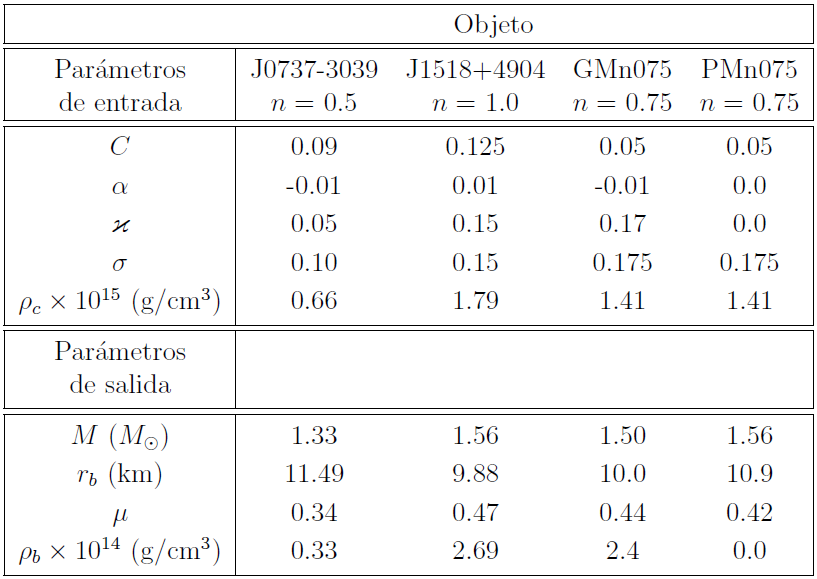

In [5]:
# Se definen los parámetros (de entrada) que caracterizan a cada modelo: n, C, alpha, varkappa,
# sigma y densidad central.

n = 0.75 # Índice polítropo

C = 0.05 # Valor del factor de anisotropía

h = 1 - 2*C  

alpha = -0.01 # valor del factor del término lineal

varkappa = 0.17 # Razón entre densidad en el borde y densidad central

sigma = 0.175 # Presión central entre densidad central

rho_c = 1.41*10**(18) # Valor de densidad central

# Cálculo de Upsilon
Upsilon = (sigma - alpha*(1 - varkappa))/(1 - varkappa**(1 + 1/n)) 

# Cálculo de kappa en función de Upsilon y densidad central
K = Upsilon*c**(2)/rho_c**(1/n)      # k**(n) en m**(3)/kg

In [6]:
# Condiciones iniciales
Psi0 = 1.0
Eta0 = 0.0
y0 = [Psi0,Eta0]

# Intervalo de integración
xi0 = 10**(-15) # Inicio
ximax = 1000    # Fin, en caso de que la condición para detener la integración no se cumpla
xi_span = (xi0,ximax) # Espacio de integración

# Condición para detener la integración (Presión adimensional menor que 10**(-15))
def stop_condition(xi,y,alpha, n, h, Upsilon, varkappa):
    return (1/sigma)*(Upsilon*(y[0]**(n+1) - varkappa**(1 + 1/n)) + alpha*(y[0]**(n) - varkappa)) - 10**-15
stop_condition.terminal = True

# Solución del sistema de ecuaciones utilizando la rutina "solve_ivp" por medio del método RK45
# solve_ivp(Ecuaciones a integrar, Espacio de integración, Condiciones iniciales, Método de integración,
#           Condición para detener la integración)
soluciones = solve_ivp(funciones,xi_span,y0,method='RK45',events=stop_condition,
                       args=(alpha, n, h, Upsilon, varkappa))
xi = soluciones.t 
Psi = soluciones.y[0]
Eta = soluciones.y[1]

C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
C:\Users\DANIEL\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


La masa total (en unidad de masa solar), el radio total (en kilómetros) y la compacidad en el borde están dados por
\begin{equation}
M = \left\{\frac{c^{2}(n+1)}{(4 \pi)^{\frac{1}{3}} G} \right\}^{\frac{3}{2}} \left(\frac{\kappa}{c^{2}} \right)^{\frac{n}{2}} \Upsilon^{\frac{3-n}{2}} \eta_{b} \,, \quad R = \left\{\frac{c^{2}(n+1)}{4 \pi G} \right\}^{\frac{1}{2}} \left(\frac{\kappa}{c^{2}} \right)^{\frac{n}{2}} \Upsilon^{\frac{1-n}{2}} \xi_{b} \,, \quad \mu = \frac{2 \Upsilon (n+1) \eta_b}{\xi_b} \,,
\end{equation}
respectivamente.

In [7]:
# Cálculo de la masa total en unidad de masa solar
M = (c**(2)*(n+1)/(4*np.pi)**(1/3)/G)**(3/2)*(K/c**(2))**(n/2)*Upsilon**((3-n)/2)*Eta[-1]/Msun  # Masa en unidades de masa solar

# Cálculo del radio total en kilómetros
R = (c**(2)*(n+1)/4/np.pi/G)**(1/2)*(K/c**(2))**(n/2)*Upsilon**((1-n)/2)*xi[-1]/1000

# Cálculo de la compacidad
mr = (2*Upsilon*(n+1)*Eta/xi)[-1]

print(f'Masa Total: {M:.2f} [M\u2609], Radio Total: {R:.2f} [km], Compacidad(\u03bc): {mr:.2f}')

Masa Total: 1.50 [M☉], Radio Total: 10.00 [km], Compacidad(μ): 0.44
